# rnavelocity - RNA Velocity

## TopCoderKitty-ML
## Tamilyn Chen, Kar-Tong Tan, Mark Lock

<hr style="height:2pt">

## Background

In an organism, cells gradually grow and develop from parental cells, to give rise to daughter cells. For instance, following fertilization of an egg, this single cell gradually grows and multiply to first give rise to precursor daughter cells (e.g. stem cells), which further grow and multiply to give rise to "granddaughter cells" like muscles, skin, brain, heart, liver, pancreas cells, etc. (Figure below)

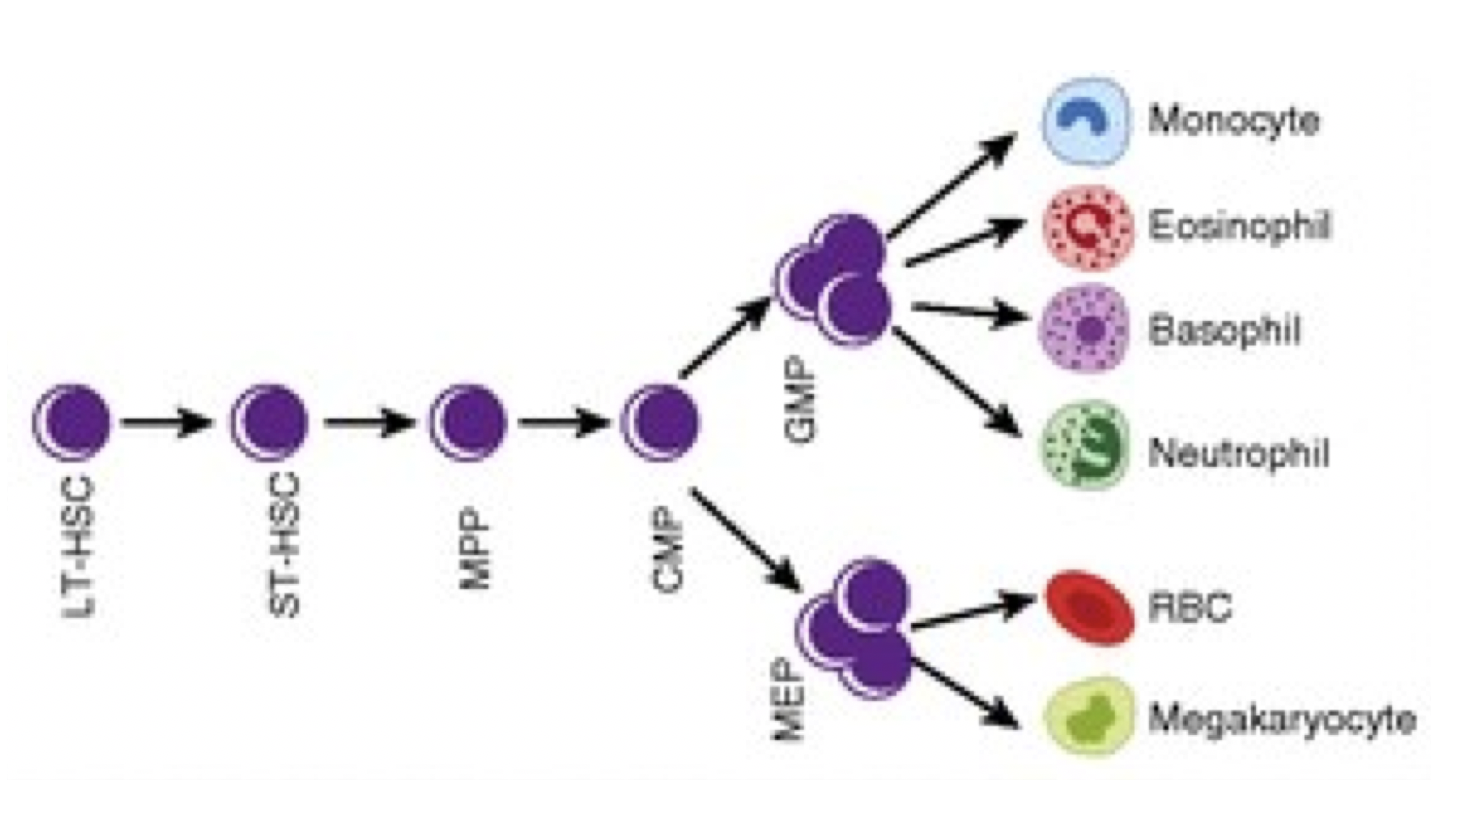

In [5]:
from IPython.display import Image
Image(filename='pics/stemcells.PNG') 

Single-cell RNA sequencing has emerged as a powerful technology for tracking these developmental changes, by enabling measurements of gene expression to be made on each and every one of these single cells. However, during single-cell RNA sequencing, each of these parental and daughter cells are mixed up. Thus, it becomes incredible difficult to distinguish which of this cells came first and are the "parents", and which of the other cells arose later on during development and are the "daughters".

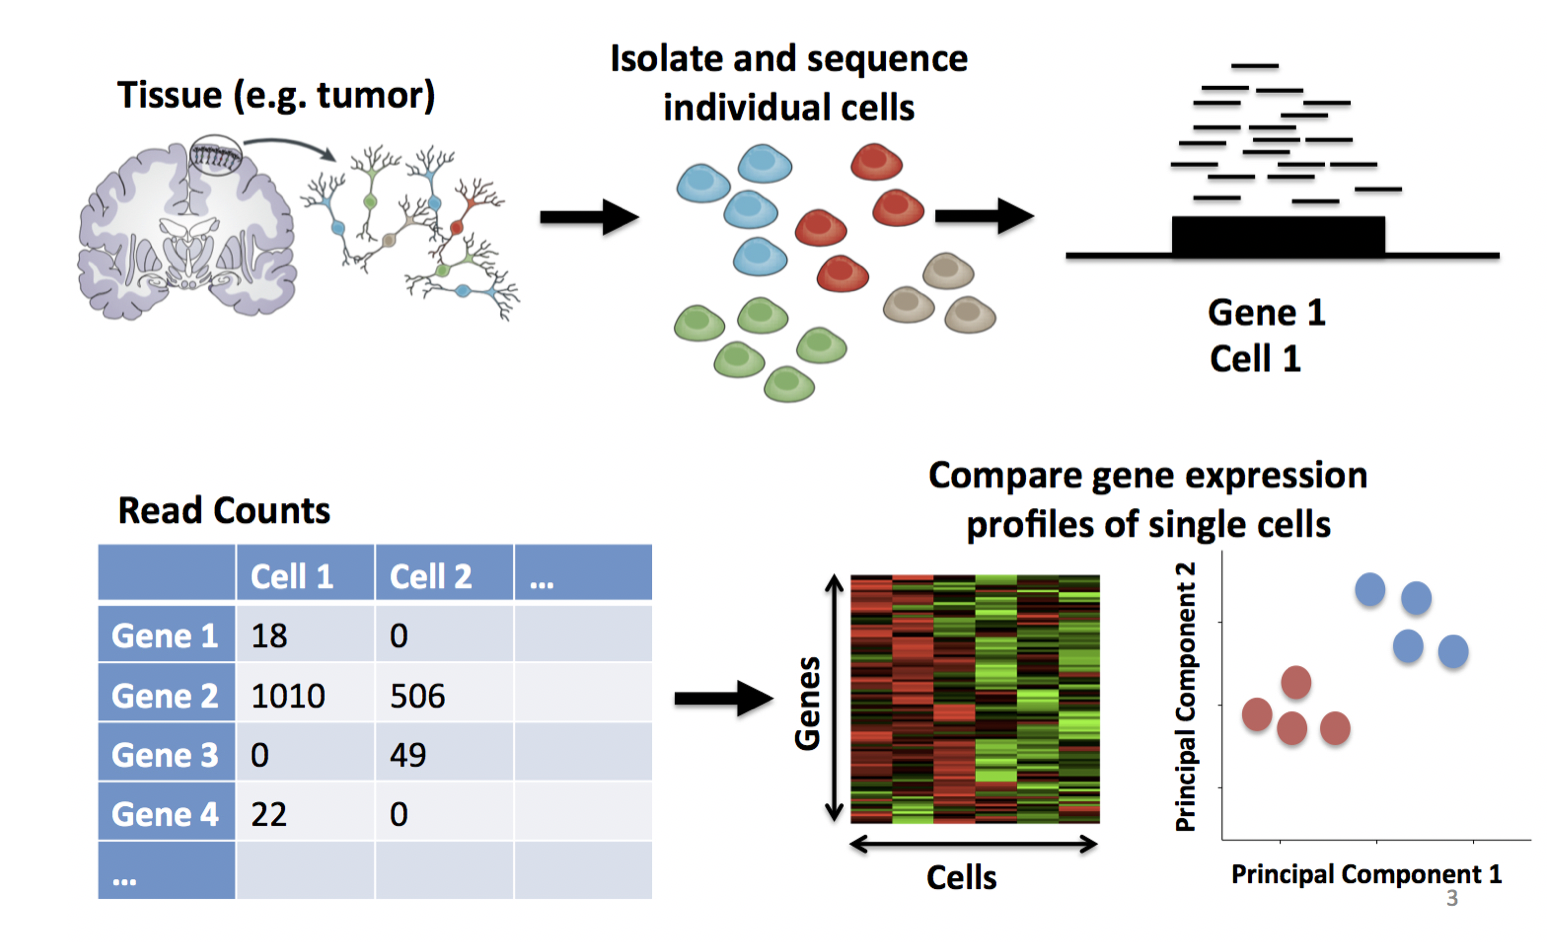

In [10]:
from IPython.display import Image
Image(filename='pics/single_cell.png') 

To resolve this, a recently published and highly cited publication by [Manno et al in Nature](https://www.nature.com/articles/s41586-018-0414-6) proposed the use of pre-cursor molecules, in tandem with their corresponding products to establish which of these cells are the "parents", and which of them are the "daughters". Briefly, a cell can be thought of as a mixture of a multitude of biological reactions, consisting of "reactants" and "products". Thus, when a "parent" cell is transitioning to become a "daughter" cell, the parental cell will express more of the reactant and less of the product, while the "daughter" cell will express less of the reactant and more of the product (Figure below). Notably, using this simple logic, we can in principle infer which cell is the "parent", and which is the "daughter" via measurements of the reactants and products in these cells.

To find an optimal arrangement for the cells in time, we propose a Markov chain where each of these cells can be individually arranged into a "parent" --> "daughter" chain. The package rnavelocity will help to do that.

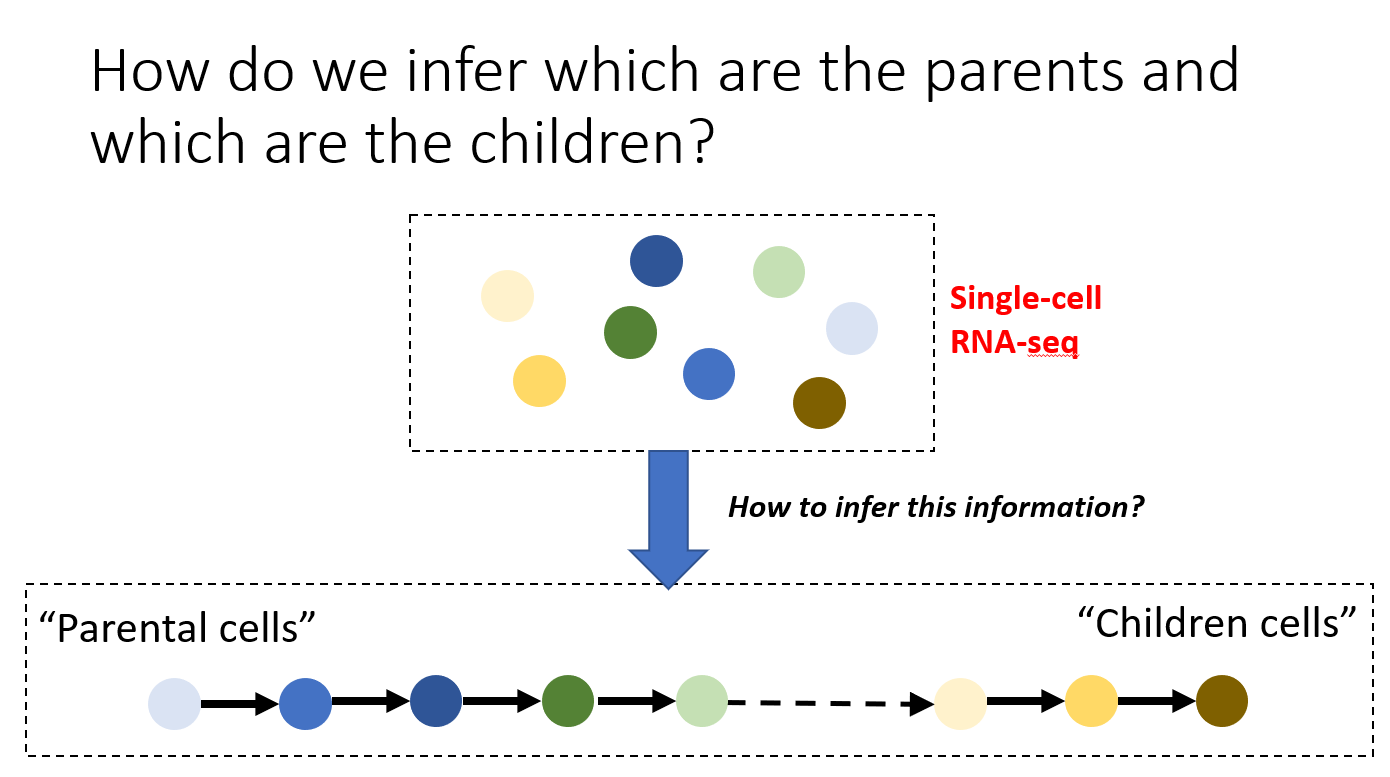

In [5]:
from IPython.display import Image
Image(filename='cells.PNG') 

## rnavelocity: derivative of single-cell gene expression state

This package calculates the RNA velocities for a given set of genes and their cells using their expression values. We can think of RNA velocities as first order derivatives specified from a functional form. The applications of RNA velocities are:

1. To serve as important and powerful indicator of future state of individual cells 
2. To distinguish between unspliced and spliced mRNAs in common single-cell RNA sequencing protocols
3. To predict future state of individual cells on a timescale of hours
4. To aid analysis of developmental lineages and cellular dynamics, particularly in humans

In the rnavelocity package we specifically attack application 4 where we will optimize for parameters:

1. alpha $\alpha$ (transcription rate)
2. gamma $\gamma$ (decay rate of the product)

We can then plug these optimized parameters into a time sorting algorithm to find the correct ordering of the lineage of cells given their genes. In simpler terms, we want to answer the chicken or egg question: "which cells were reactants that allowed other cells to develop down the line?"

The relationship between the parameters of interest, known input data, and the overall data structure can seen in the following figure below:

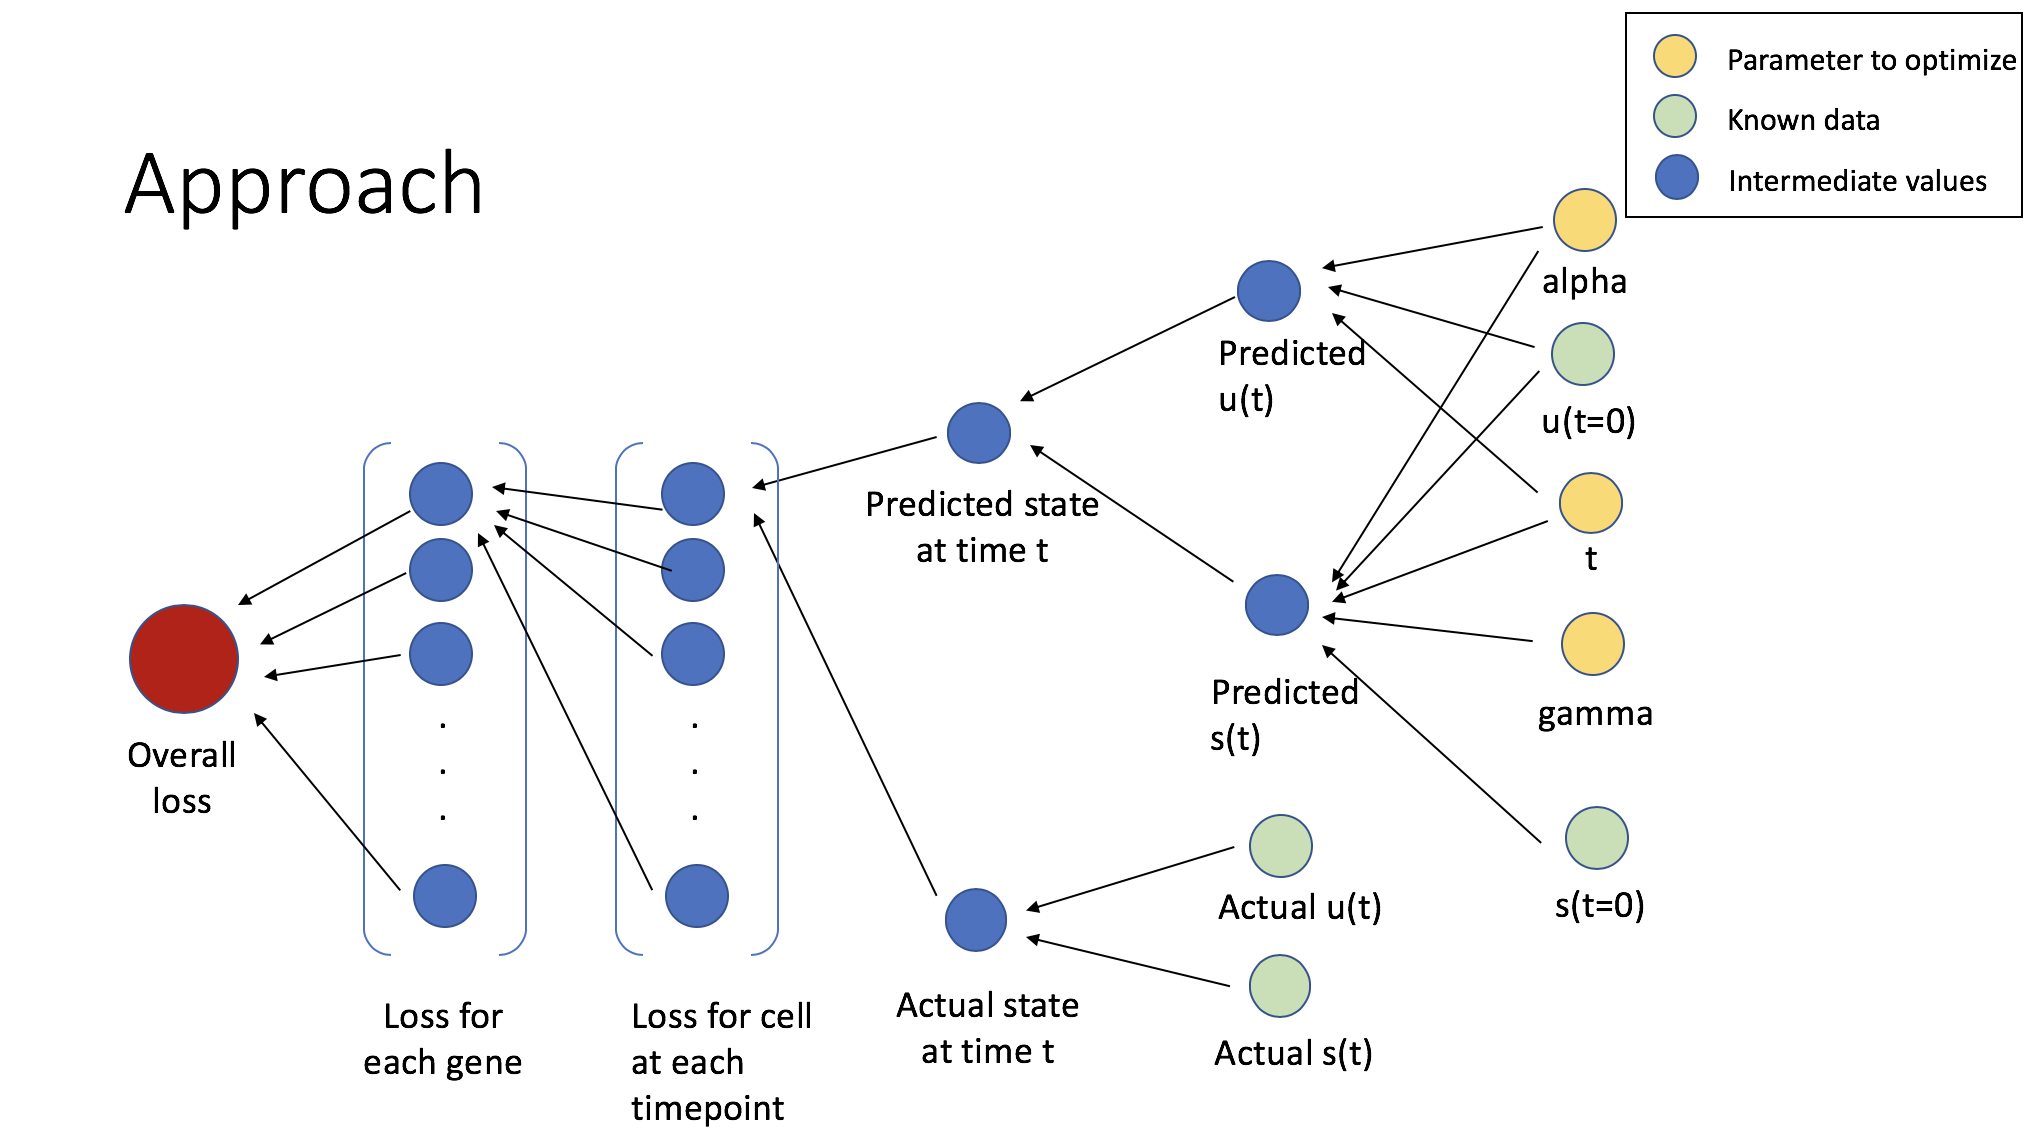

In [11]:
from IPython.display import Image
Image(filename='pics/approach.PNG') 

## Differentiation (alpha and gamma)

How do we find alpha and gamma? The idea here is we can minimize the gene expression values' distances between each cell's actual gene expression value and its predicted gene expression value (based on a best-guess sequence). The intuition is that when alpha and gamma are set correctly the actual and predicted will have very low loss in their expression values.

Because the distance function is a complex combination of many equations, we have developed a forward mode auto-differentiation package (genericdiff) that ships natively to solve this problem. This makes the problem much easier to tackle than by hand or through symbolic methods. The optimization method implemented in this package is Newton's method.

Here is the loss function for each cell $c$ which is built up by many smaller functions at the cell level $g$ (for non-biologists, a cell contains many genes).

$$loss_c = \sum_{g=1}^{n_c}\sqrt{(u_{g_{predicted}}(t, \alpha)- u_{g_{actual}})^2 + (s_{g_{predicted}}(t, \alpha, \gamma) - s_{g_{actual}})^2}$$

where $g$ represents a gene, $n_c$ represents number of genes in a cell, $u$ represents unspliced RNA expression values (level of reactants) and $s$ represents spliced RNA expression values (level of products). Actual values are provided data inputs while predicted values are calculated as follows:

$$u_{g_{predicted}}(t, \alpha) = \alpha(1-e^{-t}) + u_0e^{-t}$$

$$s_{g_{predicted}}(t, \alpha, \gamma) = \frac{e^{-t(1+\gamma)}[e^{t(1+\gamma)}\alpha(\gamma-1)+e^{t\gamma}(u_0-\alpha)\gamma+e^t(\alpha-\gamma(s_0+u_0+s_0\gamma))]}{\gamma(\gamma-1)}$$

As you can see, these expressions are very messy to differentiate symbolically and require iteration over multiple cell values, so automatic differentiation serves as the perfect tool to handle this.

This differentiation is step 3 of a bigger algorithm for finding the right cell order. This procedure is explained below.

## Algorithm to find the right cell sequence and direction

Note that a sequences consists of both order and the directionality. The full algorithm for finding the right cell order is implemented in the rnavelocity package as follows:

1. The time sorting algorithm (explained below) finds pairwise distances between cells given actual $u$ and actual $s$ data and uses a minimum spanning tree to find the sequence that gives the smallest sum of distances.

2. Then we initialize random alpha and gamma values to determine the directionality of the sequence (which end node is cell 0). There will be one end node that will give a system-wide sum of cell losses that is smaller than the other's and that node will be set as cell 0.

3. Then we invoke the differentiation procedure mentioned above to minimize the cell loss function, adjusting $\alpha$ and $\gamma$ for each cell based on newton's method (while keeping $t$ constant - which we set in step 2). 

4. After finding optimal alphas and gammas for each cell, we go back to step 2 and input the optimal alpha and gamma values to re-determine the directionality of the sequence. Directionality is important since getting a reactant-product relationship flipped could have disastrous consequences in biological applications.


## Time sorting algorithm

The time sorting algorithm takes the sum of actual u and s values from each cell for each gene and calculates the pairwise distances between all genes. Then using a minimum spanning tree, it finds the sequence of the genes that gives the smallest aggregate distance between all genes. Once this is set, an appropriate t is assigned to each gene, which can be used in the alpha gamma optimization procedure.

## Data Pre-processing
As the data is initially stored in the ".loom" format which requires a customized python library, we extracted and dumped the data into a ".pickle" object which is more readily readable across different platforms. To do so, we applied the code "extract_data.py", which extracts both the counts of unspliced reads (reactants), and spliced reads (products) from the original data structure. These data which are represented as two matrices of the same dimensions were dumped into the "hgForebrainGlut.spliced.pickle" and "hgForebrainGlut.unspliced.pickle" files.

## Data cleaning and normalization

The matrices representing the reactants (unspliced RNA) and products (spliced RNA) are extremely sparse in nature because (1) some genes within the cells are not expressed, and (2) single-cell RNA-sequencing typically is only able to subsample a fraction of the genes present within the cell. Noting this, most elements within this matrix is zero, causing the matrix to be extremely sparse. With this, most genes (columns in the matrix) will not provide much useful information in helping us determine which cells are the parental cells, and which are the daughter cells.

We expect that genes which show a significant level of counts within each cell to provide meaningful information for inference of the parental or daughter nature of each cells. To address this, we removed genes (columns) which showed only a very low count of reads within the data for both the 'spliced' and 'unspliced' data.

## How to install

To get the rnavelocity package, install the following from pip using the command line. 

rnavelocity-genericdiff is the bundle that contains the rnavelocity package and genericdiff package.

In [ ]:
python -m pip install rnavelocity-genericdiff

### Import the package
To import the package

In [ ]:
from rnavelocity import *

## How to use

### Get sample data
We have provided sample data based on the data extraction procedure we used to get actual u and s values from the .loom files. As the loom files are difficult to parse with standard libraries. We have extracted these data and dumped these data as .pickle files which are much mroe readily readable. These files are found under the "processed_data" directory in the rnavelocity package

Note that the full data set that we have extracted is too big to be directly uploaded. These files are thus provided as gzipped files. You will need to unzip them if you will like to work from the raw files. Further, we have also provided the filtered picked files which have been filtered, scaled, and can be directly used for the optimization process

### Optimize parameters using package
The whole package has been packaged such that it only requires a ".pickle" file carrying the input data of the gene expression. Specifically, the ".pickle" file needs to be a m * n * o matrix where:

m : spliced data in layer 0, unspliced data in layer 1

n : Genes (~200+ filtered genes in the sample data)

o : Cells (~1800+ cells in the sample data)

### Optimize for alpha and gamma

The following command will automatically take the pickle file in, perform a time sort, and then optimize for the parameters of interest (alpha and gamma)

In [ ]:
# instantiate RNAOptimize class with u and s functions
opt = RNAOptimize(input_pickle_file = "processed_data/norm_filtered_cells.scaled.pickle", \
    num_processes = 4, cached=True)

### Pull ordered sequence of cells

Following optimization, we can get the sequence of cells in temporal order as such as a list. The list represents the index of the input cells.

In [ ]:
sequence = opt.get_sequence()

### Pull parameters derived after optimization

We can also look at the parameters we get after optimization. Specifically, column 1 represents the gene_index, column 2 the alpha parameter for the gene, and column 3 the gamma parameter for the gene

In [ ]:
parameters = opt.get_parameters()

### Sample plots generated from the parameters and the deduced temporal ordering of cells

We can get the following plots following the optimization process. The following depicts the gene with the highest and lowest synthesis rate (alpha), and highest and lowest decay rate (gamma). The plots can be generated using the corresponding ipython notebook in the directory "generate_plot.ipynb".

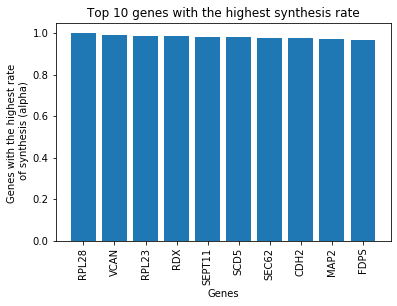

In [13]:
from IPython.display import Image
Image(filename='pics/synthesis_top10_highest.png')

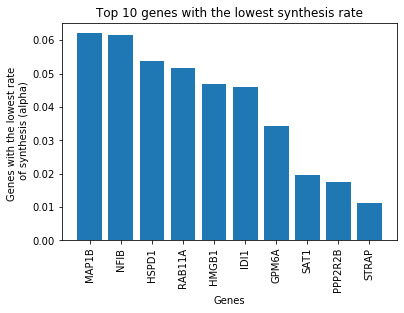

In [14]:
Image(filename='pics/synthesis_top10_lowest.png')

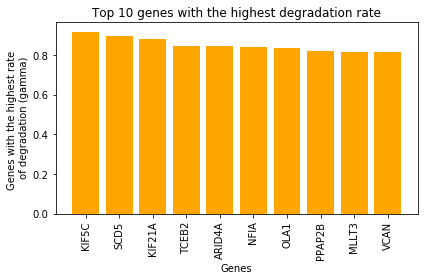

In [15]:
Image(filename='pics/degradation_top10_highest.png')

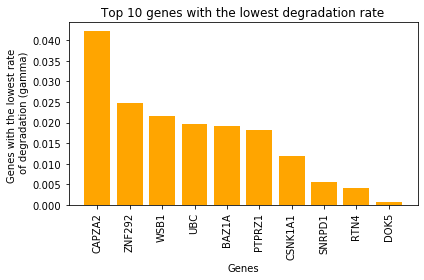

In [16]:
Image(filename='pics/degradation_top10_lowest.png')

We can also generate the following pseudotime plot from the data, which tells how the levels of the spliced and unspliced genes changes with time, based on the time we inferred from the data

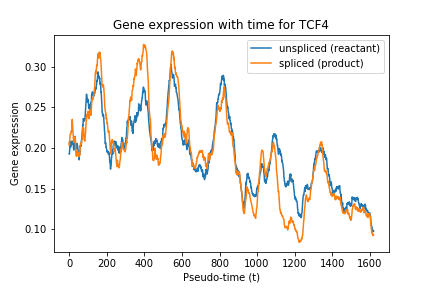

In [22]:
Image(filename='pics/pseudotime_example5.png')

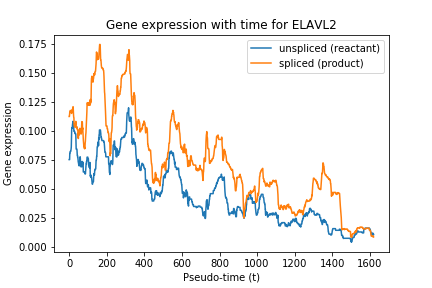

In [23]:
Image(filename='pics/pseudotime_example6.png')